In [1]:
from google.colab import files
files.upload()  # Upload the kaggle.json file

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"amarhamouma","key":"3c2351ea67223cf466bcfac2419b0568"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json  # Set permissions

In [3]:
!kaggle datasets download -d grouplens/movielens-20m-dataset

Dataset URL: https://www.kaggle.com/datasets/grouplens/movielens-20m-dataset
License(s): unknown
100% 195M/195M [00:01<00:00, 116MB/s]
100% 195M/195M [00:01<00:00, 123MB/s]


In [4]:
!unzip movielens-20m-dataset.zip

Archive:  movielens-20m-dataset.zip
  inflating: genome_scores.csv       
  inflating: genome_tags.csv         
  inflating: link.csv                
  inflating: movie.csv               
  inflating: rating.csv              
  inflating: tag.csv                 


Iterations: 100%|██████████| 20/20 [23:01<00:00, 69.07s/it]


Top 10 Most Recommended Movies:
item_id  movie_title                              
260      Star Wars: Episode IV - A New Hope (1977)    213457
480      Jurassic Park (1993)                         106194
1196     Unknown Movie                                 35496
1        Toy Story (1995)                              11022
1210     Unknown Movie                                  8121
1097     Unknown Movie                                  3224
110      Braveheart (1995)                              2754
364      Lion King, The (1994)                          2385
318      Shawshank Redemption, The (1994)               2327
1198     Unknown Movie                                  2207
dtype: int64


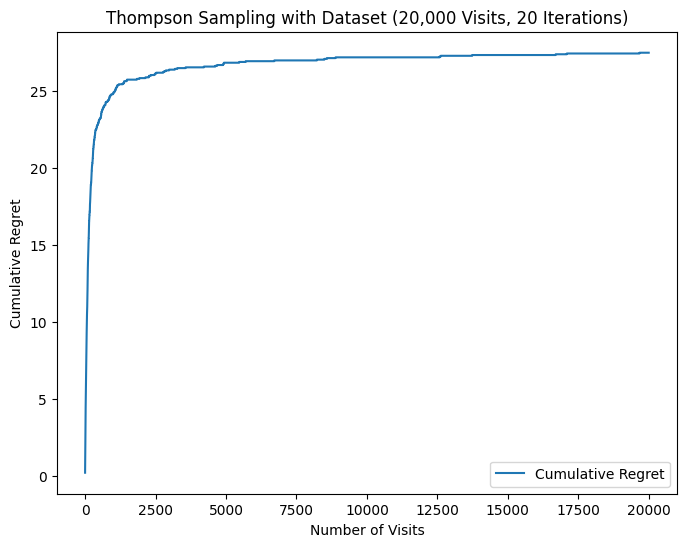

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm  # For progress bars

def thompson_sampling_with_dataset(n_visits, reward_history, movies_metadata, item_col_name, visitor_col_name, reward_col_name, n_iterations=1, epsilon=0.7, decay_rate=0.95):
    """
    Simulate Thompson Sampling using a subset of the dataset and include movie titles.
    Args:
        n_visits (int): Number of visits to simulate per iteration.
        reward_history (pd.DataFrame): Historical data containing visitor-item interactions and rewards.
        movies_metadata (pd.DataFrame): Movie metadata containing movieId and title.
        item_col_name (str): Column name for items (e.g., movies).
        visitor_col_name (str): Column name for visitors (e.g., users).
        reward_col_name (str): Column name for rewards (e.g., liked or not).
        n_iterations (int): Number of iterations to average over.
        epsilon (float): Initial exploration rate.
        decay_rate (float): Decay rate for exploration.
    Returns:
        pd.DataFrame: Results of the simulation.
    """
    # Create a mapping from movieId to movie title
    movie_name_mapping = dict(zip(movies_metadata["movieId"], movies_metadata["title"]))

    # Filter the dataset to use a subset of movies (e.g., top 50 most-rated movies)
    movie_rating_counts = reward_history.groupby(item_col_name)[reward_col_name].count()
    top_movies = movie_rating_counts.nlargest(50).index  # Select top 50 most-rated movies
    reward_history = reward_history[reward_history[item_col_name].isin(top_movies)]

    # Get unique items and visitors
    items = reward_history[item_col_name].unique()
    visitors = reward_history[visitor_col_name].unique()
    n_items = len(items)
    n_visitors = len(visitors)

    # Initialize results storage
    all_results = []

    # Run simulations
    for iteration in tqdm(range(n_iterations), desc="Iterations"):
        # Reset algorithm state
        alphas = np.ones(n_items)  # Success counts for each item
        betas = np.ones(n_items)   # Failure counts for each item
        epsilon_current = epsilon  # Current exploration rate

        # Initialize metrics
        cumulative_regret = 0
        total_rewards = 0

        # Simulate visits
        for visit in range(n_visits):
            found_match = False
            while not found_match:
                # Choose a random visitor
                visitor_idx = np.random.randint(n_visitors)
                visitor_id = visitors[visitor_idx]

                # Select an item to offer the visitor
                if np.random.random() < epsilon_current:
                    item_idx = np.random.randint(n_items)  # Explore: choose a random item
                else:
                    # Exploit: choose the item with the highest sampled mean
                    samples = [np.random.beta(alphas[i], betas[i]) for i in range(n_items)]
                    item_idx = np.argmax(samples)

                item_id = items[item_idx]

                # Check if the pair exists in the historical data
                reward = reward_history.query(
                    '{} == @item_id and {} == @visitor_id'.format(item_col_name, visitor_col_name)
                )[reward_col_name]

                found_match = reward.shape[0] > 0

            reward_value = reward.iloc[0]

            # Update algorithm state
            if reward_value == 1:
                alphas[item_idx] += 1
            else:
                betas[item_idx] += 1

            # Decay the exploration rate
            epsilon_current *= decay_rate

            # Calculate cumulative regret
            # Since true reward probabilities are unknown, we assume the optimal reward is 1 (liked)
            optimal_reward = 1
            regret = optimal_reward - reward_value
            cumulative_regret += regret

            # Get the movie title using the movieId
            movie_title = movie_name_mapping.get(item_id, "Unknown Movie")

            # Store results
            result = {
                'iteration': iteration,
                'visit': visit,
                'item_id': item_id,
                'movie_title': movie_title,  # Include movie title in results
                'visitor_id': visitor_id,
                'reward': reward_value,
                'cumulative_regret': cumulative_regret,
                'alpha': alphas[item_idx],  # Include alpha in results
                'beta': betas[item_idx]    # Include beta in results
            }
            all_results.append(result)

    # Convert results to a DataFrame
    results_df = pd.DataFrame(all_results)
    return results_df

# Main function to run Thompson Sampling on MovieLens
if __name__ == "__main__":
    # Load the dataset (replace with your dataset path and processing steps)
    reward_history = pd.read_csv("rating.csv")  # Example: Load the MovieLens ratings dataset
    movies_metadata = pd.read_csv("movie.csv")  # Example: Load the MovieLens movies metadata
    reward_history["liked"] = (reward_history["rating"] >= 4).astype(int)  # Convert ratings to binary (liked or not liked)

    reward_history = reward_history[:1000]
    movies_metadata = movies_metadata[:1000]

    # Run the simulation
    n_visits = 20000  # Number of visits per iteration
    n_iterations = 20  # Number of iterations
    results_df = thompson_sampling_with_dataset(
        n_visits=n_visits,
        reward_history=reward_history,
        movies_metadata=movies_metadata,
        item_col_name="movieId",
        visitor_col_name="userId",
        reward_col_name="liked",
        n_iterations=n_iterations,
        epsilon=0.5,  # Initial exploration rate
        decay_rate=0.95  # Decay rate for exploration
    )

    # Save results to disk
    results_df.to_csv("simulation_results.csv", index=False)

    # Print the top 10 most recommended movies (with titles)
    top_movies = results_df.groupby(["item_id", "movie_title"]).size().nlargest(10)
    print("Top 10 Most Recommended Movies:")
    print(top_movies)

    # Plot cumulative regret averaged over iterations
    avg_regret = results_df.groupby("visit")["cumulative_regret"].mean()
    plt.figure(figsize=(8, 6))
    plt.plot(avg_regret.index, avg_regret.values, label="Cumulative Regret")
    plt.title("Thompson Sampling with Dataset (20,000 Visits, 20 Iterations)")
    plt.xlabel("Number of Visits")
    plt.ylabel("Cumulative Regret")
    plt.legend()
    plt.show()

In [ ]:
# Calculate true reward probabilities for each movie
true_reward_probs = reward_history.groupby("movieId")["liked"].mean()

# Compare with the algorithm's posterior means
posterior_means = results_df.groupby("item_id").apply(
    lambda x: (x["alpha"].mean() / (x["alpha"].mean() + x["beta"].mean()))
)

# Print comparison
comparison = pd.DataFrame({
    "True Probability": true_reward_probs,
    "Posterior Mean": posterior_means
}).dropna()
print(comparison.head(15))

     True Probability  Posterior Mean
1            1.000000        0.997850
3            0.500000        0.461538
10           0.666667        0.714815
11           1.000000        0.977631
17           0.333333        0.551181
19           0.000000        0.328125
32           0.500000        0.569231
62           1.000000        0.971043
110          1.000000        0.993516
150          1.000000        0.969802
165          0.333333        0.575000
173          0.333333        0.518868
253          1.000000        0.982437
260          1.000000        0.999850
296          0.666667        0.690678


<ipython-input-87-c596ddaf57af>:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  posterior_means = results_df.groupby("item_id").apply(


In [ ]:
def validate_results(results_df, reward_history, movies_metadata):
    """
    Validate the results by comparing posterior means with true reward probabilities.
    Args:
        results_df (pd.DataFrame): Results of the simulation.
        reward_history (pd.DataFrame): Historical data containing visitor-item interactions and rewards.
        movies_metadata (pd.DataFrame): Movie metadata containing movieId and title.
    """
    # Calculate true reward probabilities for each movie
    true_reward_probs = reward_history.groupby("movieId")["liked"].mean()

    # Calculate posterior means from the results
    results_df["posterior_mean"] = results_df["alpha"] / (results_df["alpha"] + results_df["beta"])

    # Aggregate results by movieId
    comparison = results_df.groupby("item_id").agg({
        "posterior_mean": "mean",
        "movie_title": "first"  # Include movie title for clarity
    }).join(true_reward_probs.rename("true_probability"), on="item_id")

    # Add movie titles from movies_metadata
    comparison = comparison.join(movies_metadata.set_index("movieId")["title"], on="item_id")

    # Print comparison
    print("Comparison of Posterior Means and True Probabilities:")
    print(comparison.head(15))

In [ ]:
validate_results(results_df=results_df, reward_history=reward_history, movies_metadata=movies_metadata)

Comparison of Posterior Means and True Probabilities:
         posterior_mean                                        movie_title  \
item_id                                                                      
1              0.991407                                   Toy Story (1995)   
3              0.551323                            Grumpier Old Men (1995)   
10             0.662518                                   GoldenEye (1995)   
11             0.924221                     American President, The (1995)   
17             0.453333                       Sense and Sensibility (1995)   
19             0.333333              Ace Ventura: When Nature Calls (1995)   
32             0.517336          Twelve Monkeys (a.k.a. 12 Monkeys) (1995)   
62             0.946472                          Mr. Holland's Opus (1995)   
110            0.973054                                  Braveheart (1995)   
150            0.948094                                   Apollo 13 (1995)   
165       

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm  # For progress bars

In [7]:
def load_data(ratings_file, movies_file, min_ratings=50):
    """
    Load and preprocess the dataset.
    Args:
        ratings_file (str): Path to the ratings file (e.g., rating.csv).
        movies_file (str): Path to the movies metadata file (e.g., movies.csv).
        min_ratings (int): Minimum number of ratings for a movie to be included.
    Returns:
        pd.DataFrame: Preprocessed reward history.
        pd.DataFrame: Movies metadata.
    """
    # Load ratings and movies metadata
    reward_history = pd.read_csv(ratings_file)
    movies_metadata = pd.read_csv(movies_file)

    reward_history = reward_history
    movies_metadata = movies_metadata
    # Convert ratings to binary (liked or not liked)
    reward_history["liked"] = (reward_history["rating"] >= 4).astype(int)

    # Filter movies with at least min_ratings
    movie_rating_counts = reward_history.groupby("movieId")["liked"].count()
    valid_movies = movie_rating_counts[movie_rating_counts >= min_ratings].index
    reward_history = reward_history[reward_history["movieId"].isin(valid_movies)]

    return reward_history, movies_metadata

In [8]:
def thompson_sampling_step(alphas, betas, epsilon, items, visitors, reward_history, item_col_name, visitor_col_name, reward_col_name):
    """
    Perform one step of Thompson Sampling.
    Args:
        alphas (np.array): Alpha parameters for each item.
        betas (np.array): Beta parameters for each item.
        epsilon (float): Current exploration rate.
        items (np.array): List of item IDs.
        visitors (np.array): List of visitor IDs.
        reward_history (pd.DataFrame): Historical data containing visitor-item interactions and rewards.
        item_col_name (str): Column name for items (e.g., movies).
        visitor_col_name (str): Column name for visitors (e.g., users).
        reward_col_name (str): Column name for rewards (e.g., liked or not).
    Returns:
        int: Selected item index.
        int: Observed reward.
    """
    found_match = False
    while not found_match:
        # Choose a random visitor
        visitor_idx = np.random.randint(len(visitors))
        visitor_id = visitors[visitor_idx]

        # Select an item to offer the visitor
        if np.random.random() < epsilon:
            item_idx = np.random.randint(len(items))  # Explore: choose a random item
        else:
            # Exploit: choose the item with the highest sampled mean
            samples = [np.random.beta(alphas[i], betas[i]) for i in range(len(items))]
            item_idx = np.argmax(samples)

        item_id = items[item_idx]

        # Check if the pair exists in the historical data
        reward = reward_history.query(
            '{} == @item_id and {} == @visitor_id'.format(item_col_name, visitor_col_name)
        )[reward_col_name]

        found_match = reward.shape[0] > 0

    reward_value = reward.iloc[0]
    return item_idx, reward_value

In [14]:
def run_simulation(n_visits, reward_history, movies_metadata, item_col_name, visitor_col_name, reward_col_name, n_iterations=1, epsilon=0.5, decay_rate=0.95):
    """
    Run the Thompson Sampling simulation, limiting to 3000 films.
    Args:
        n_visits (int): Number of visits to simulate per iteration.
        reward_history (pd.DataFrame): Historical data containing visitor-item interactions and rewards.
        movies_metadata (pd.DataFrame): Movie metadata containing movieId and title.
        item_col_name (str): Column name for items (e.g., movies).
        visitor_col_name (str): Column name for visitors (e.g., users).
        reward_col_name (str): Column name for rewards (e.g., liked or not).
        n_iterations (int): Number of iterations to average over.
        epsilon (float): Initial exploration rate.
        decay_rate (float): Decay rate for exploration.
    Returns:
        pd.DataFrame: Results of the simulation.
    """
    # Create a mapping from movieId to movie title
    movie_name_mapping = dict(zip(movies_metadata["movieId"], movies_metadata["title"]))

    # Filter the dataset to include only 3000 films
    unique_movies = reward_history[item_col_name].unique()
    selected_movies = np.random.choice(unique_movies, size=3000, replace=False)  # Randomly select 3000 movies
    reward_history = reward_history[reward_history[item_col_name].isin(selected_movies)]

    # Get unique items and visitors
    items = reward_history[item_col_name].unique()
    visitors = reward_history[visitor_col_name].unique()

    # Initialize results storage
    all_results = []

    # Run simulations
    for iteration in tqdm(range(n_iterations), desc="Iterations"):
        # Reset algorithm state
        alphas = np.ones(len(items))  # Success counts for each item
        betas = np.ones(len(items))   # Failure counts for each item
        epsilon_current = epsilon  # Current exploration rate

        # Initialize metrics
        cumulative_regret = 0

        # Simulate visits
        for visit in range(n_visits):
            # Perform one step of Thompson Sampling
            item_idx, reward_value = thompson_sampling_step(
                alphas, betas, epsilon_current, items, visitors, reward_history,
                item_col_name, visitor_col_name, reward_col_name
            )

            # Update algorithm state
            if reward_value == 1:
                alphas[item_idx] += 1
            else:
                betas[item_idx] += 1

            # Decay the exploration rate
            epsilon_current *= decay_rate

            # Calculate cumulative regret
            optimal_reward = 1  # Assume the best possible reward is 1 (liked)
            regret = optimal_reward - reward_value
            cumulative_regret += regret

            # Get the movie title using the movieId
            item_id = items[item_idx]
            movie_title = movie_name_mapping.get(item_id, "Unknown Movie")

            # Store results
            result = {
                'iteration': iteration,
                'visit': visit,
                'item_id': item_id,
                'movie_title': movie_title,  # Include movie title in results
                'visitor_id': visitors[np.random.randint(len(visitors))],  # Random visitor for this step
                'reward': reward_value,
                'cumulative_regret': cumulative_regret,
                'alpha': alphas[item_idx],  # Include alpha in results
                'beta': betas[item_idx]    # Include beta in results
            }
            all_results.append(result)

    # Convert results to a DataFrame
    results_df = pd.DataFrame(all_results)
    return results_df

In [10]:
def validate_results(results_df, reward_history):
    """
    Validate the results by comparing posterior means with true reward probabilities.
    Args:
        results_df (pd.DataFrame): Results of the simulation.
        reward_history (pd.DataFrame): Historical data containing visitor-item interactions and rewards.
    """
    # Calculate true reward probabilities for each movie
    true_reward_probs = reward_history.groupby("movieId")["liked"].mean()

    # Calculate posterior means from the results
    results_df["posterior_mean"] = results_df["alpha"] / (results_df["alpha"] + results_df["beta"])

    # Compare with the true reward probabilities
    comparison = results_df.groupby("item_id").agg({
        "posterior_mean": "mean",
        "movie_title": "first"  # Include movie title for clarity
    }).join(true_reward_probs.rename("true_probability"), on="item_id")

    # Print comparison
    print("Comparison of Posterior Means and True Probabilities:")
    print(comparison.head(10))

In [11]:
def plot_results(results_df):
    """
    Plot the cumulative regret over time.
    Args:
        results_df (pd.DataFrame): Results of the simulation.
    """
    # Plot cumulative regret averaged over iterations
    avg_regret = results_df.groupby("visit")["cumulative_regret"].mean()
    plt.figure(figsize=(8, 6))
    plt.plot(avg_regret.index, avg_regret.values, label="Cumulative Regret")
    plt.title("Thompson Sampling with Dataset (20,000 Visits, 20 Iterations)")
    plt.xlabel("Number of Visits")
    plt.ylabel("Cumulative Regret")
    plt.legend()
    plt.show()

In [ ]:
# Main function to run Thompson Sampling on MovieLens
if __name__ == "__main__":
    # Load and preprocess the dataset
    reward_history, movies_metadata = load_data("rating.csv", "movie.csv", min_ratings=50)

    # Run the simulation
    n_visits = 20000  # Number of visits per iteration
    n_iterations = 20  # Number of iterations
    results_df = run_simulation(
        n_visits=n_visits,
        reward_history=reward_history,
        movies_metadata=movies_metadata,
        item_col_name="movieId",
        visitor_col_name="userId",
        reward_col_name="liked",
        n_iterations=n_iterations,
        epsilon=0.5,  # Initial exploration rate
        decay_rate=0.95  # Decay rate for exploration
    )

    # Save results to disk
    results_df.to_csv("simulation_results.csv", index=False)

    # Validate the results
    validate_results(results_df, reward_history)

    # Plot the results
    plot_results(results_df)

Iterations:   0%|          | 0/20 [00:00<?, ?it/s]